In [55]:
#importing required packages
import sys
import os

import re #regular expression

import pandas as pd #pandas data frame for holding the data
from bs4 import BeautifulSoup #for cleaning the html boilerplate
from nltk.corpus import stopwords #import the stopword list from nltk library
from nltk.stem import WordNetLemmatizer #import the lemmatizer from nltk

from sklearn.feature_extraction.text import TfidfVectorizer #import tfidf vectorizer from scikit-learn
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression #import the logistic regression model from scikit-learn

from sklearn.metrics import confusion_matrix #import the confusion matrix
from sklearn.metrics import classification_report #import the classification report to compute recall, prec, etc


In [56]:
#loading the training dataset
train_data = pd.read_csv('/Users/meimei/Documents/UT1/Data Analytics/imbd_movie_review_dataset/labeledTrainData.tsv.zip', header=0, delimiter='\t')

#Show the top part of the data table
train_data.head()


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [57]:
#Get the basic information about the data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [58]:
#Get the X variables
X_train = train_data.drop(["sentiment"], axis=1)
X_train.head()

,id,review
0,5814_8,With all this stuff going down at the moment w...
1,2381_9,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,The film starts with a manager (Nicholas Bell)...
3,3630_4,It must be assumed that those who praised this...
4,9495_8,Superbly trashy and wondrously unpretentious 8...


In [59]:
#Get the u variables
y_train = train_data["sentiment"]
y_train.head()

0    1
1    1
2    0
3    0
4    1
Name: sentiment, dtype: int64

<AxesSubplot:ylabel='sentiment'>

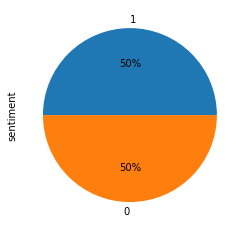

In [60]:
#Is the data balanced?
y_train.value_counts().plot(kind='pie', autopct='%1.0f%%')

In [61]:
#transforming negation abbreviated text to standard text
re_negation = re.compile("n't ") #regular expression rule

def negation_abbreviation_to_regular(abbreviated_text):
    '''
    aren't -> are not 
    '''
    regular_text = re_negation.sub(' not ', abbreviated_text)    
    return regular_text

In [62]:
#get the stopwords list from the nltk library
stopwords_list = set(stopwords.words("english"))

In [63]:
#lemmatized the words
lemmatizer = WordNetLemmatizer()

def get_lemmatized_words(words_list):
    '''
        cats -> cat
        houses to house
        apples to apple
        started to start (v)
    '''    
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words_list]
    lemmatized_words = [lemmatizer.lemmatize(word, "v") for word in lemmatized_words]
    
    return lemmatized_words

In [64]:
def get_clean_review(raw_review):
    '''
        cleaning the review text
    '''
    #remove html tags from the raw review
    review_text = BeautifulSoup(raw_review).get_text()
    
    #transforming the negation abbreviated terms to regular terms
    review_text_regular = negation_abbreviation_to_regular(review_text)
    
    #removing non-alphanumeric terms
    review_text_alphanum = re.sub("[^a-zA-Z_0-9]", " ", review_text_regular)
    
    #converting the characters into lowercase
    review_text_lower_case = review_text_alphanum.lower()

    #tokenize the text into words
    review_words = review_text_lower_case.split()
    
    #removing stop words
    review_words_meaningful = [word for word in review_words if word not in stopwords_list]
    
    #lematization
    review_words_lemmatized = get_lemmatized_words(review_words_meaningful)
    
    clean_review = " ".join(review_words_lemmatized)
    return clean_review

In [65]:
#cleaning reviews
train_reviews_clean = []
for review in X_train['review']:
    clean_review = get_clean_review(review)
    train_reviews_clean.append(clean_review)

In [66]:
#vectorization the text data
#vectorizer = TfidfVectorizer(max_features=10000, ngram_range = (1,2))
#vectorizer = HashingVectorizer(n_features=10000, ngram_range = (1,2))
#vectorizer = CountVectorizer(max_features=10000, ngram_range = (1,2))
vectorizer = CountVectorizer(ngram_range = (1,2))

In [67]:
X_train_features = vectorizer.fit_transform(train_reviews_clean)
X_train_features.shape

(25000, 1612070)

In [68]:
#Training machine learning model (Logistic regression)
# Define the model
model = LogisticRegression(random_state=0)
model.fit(X_train_features, y_train)
print(model.intercept_)
print(model.coef_[0])

[0.1308782]
[-0.10382901  0.00017859 -0.02131132 ... -0.00017917 -0.00017917
 -0.00017917]


/Users/meimei/miniconda3/envs/DT/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
#prediction on the training dataset
y_train_pred = model.predict(X_train_features)

In [45]:
#confusion matrix for the training dataset
confusion_matrix_lr = confusion_matrix(y_train, y_train_pred, labels=[1,0])
confusion_matrix_lr

array([[12436,    64],
       [   81, 12419]])

In [46]:
#classification report for the trianing dataset
cls_report = classification_report(y_train, y_train_pred)
print (cls_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12500
           1       0.99      0.99      0.99     12500

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000



In [47]:
#processing the test dataset

#loading the testing dataset
test_data = pd.read_csv('/Users/meimei/Documents/UT1/Data Analytics/imbd_movie_review_dataset/testData.tsv.zip', header=0, delimiter='\t')

#Show the top part of the data table
test_data.head()


,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [48]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25000 non-null  object
 1   review  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [49]:
X_test = test_data['review']
X_test[0]

"Naturally in a film who's main themes are of mortality, nostalgia, and loss of innocence it is perhaps not surprising that it is rated more highly by older viewers than younger ones. However there is a craftsmanship and completeness to the film which anyone can enjoy. The pace is steady and constant, the characters full and engaging, the relationships and interactions natural showing that you do not need floods of tears to show emotion, screams to show fear, shouting to show dispute or violence to show anger. Naturally Joyce's short story lends the film a ready made structure as perfect as a polished diamond, but the small changes Huston makes such as the inclusion of the poem fit in neatly. It is truly a masterpiece of tact, subtlety and overwhelming beauty."

In [50]:
#cleaning test reviews
test_reviews_clean = []
for review in X_test:
    clean_review = get_clean_review(review)
    test_reviews_clean.append(clean_review)

In [51]:
#vectorize the test reviews
X_test_features = vectorizer.fit_transform(test_reviews_clean)


In [52]:
#predict the test review features on the trained model
test_pred = model.predict(X_test_features)

In [53]:
test_pred[0:5]

array([0, 0, 1, 1, 0])

In [54]:
test_output = pd.DataFrame(data={"id":test_data['id'], "sentiment":test_pred})
print(test_output.head())

test_output.to_csv('/Users/meimei/Documents/UT1/Data Analytics/imbd_movie_review_dataset/test_sentiment_prediction.csv', index=False)

         id  sentiment
0  12311_10          0
1    8348_2          0
2    5828_4          1
3    7186_2          1
4   12128_7          0
